## Import Modules

In [36]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

## Load the Dataset

In [37]:
# DATASET = 'affectnet'
# DATASET = 'fer2013'
DATASET = 'mma'

TRAIN_DIR = f"input/{DATASET}/train/"
TEST_DIR = f"input/{DATASET}/test/"
VALID_DIR = f"input/{DATASET}/valid/"

In [38]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        # print(label, "Completed")

    return image_paths, labels

In [39]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True) # shuffle

train.head()

,image,label
0,input/mma/train/neutral\87221Exp6awe_asian_626...,neutral
1,input/mma/train/sad\21869Exp4annoyed_son_222.jpg,sad
2,input/mma/train/happy\49601Exp3awe_couple_387.jpg,happy
3,input/mma/train/happy\Happy.19546.jpg,happy
4,input/mma/train/neutral\43507Exp6heartbroken_f...,neutral


In [40]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test = test.sample(frac=1).reset_index(drop=True)

test.head()

,image,label
0,input/mma/test/surprise\50495Exp5shocked_expre...,surprise
1,input/mma/test/happy\53764Exp3amazed_chinese_7...,happy
2,input/mma/test/neutral\49330Exp6awe_american_5...,neutral
3,input/mma/test/happy\88576Exp3awe_infant_804.jpg,happy
4,input/mma/test/happy\Happy.34409.jpg,happy


In [41]:
valid = pd.DataFrame()
valid['image'], valid['label'] = load_dataset(VALID_DIR)
valid = valid.sample(frac=1).reset_index(drop=True)

valid.head()

,image,label
0,input/mma/valid/happy\60569Exp3amazed_wife_605...,happy
1,input/mma/valid/disgust\48942Exp1astound_man_3...,disgust
2,input/mma/valid/neutral\75265Exp6amazed_man_33...,neutral
3,input/mma/valid/neutral\9870Exp6fighting_mothe...,neutral
4,input/mma/valid/neutral\30745Exp6unhappy_expre...,neutral


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

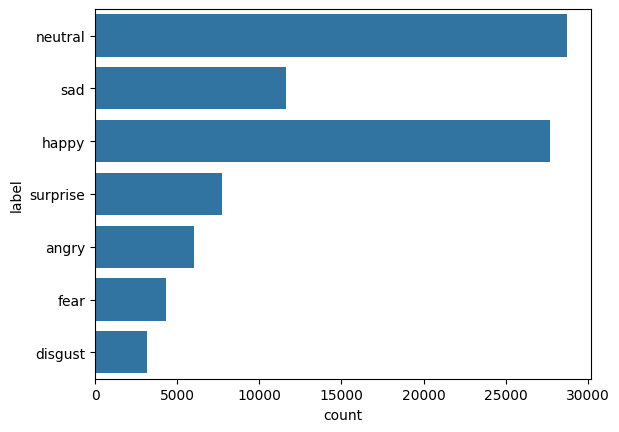

In [42]:
sns.countplot(train['label'])

## Grid of dataset images

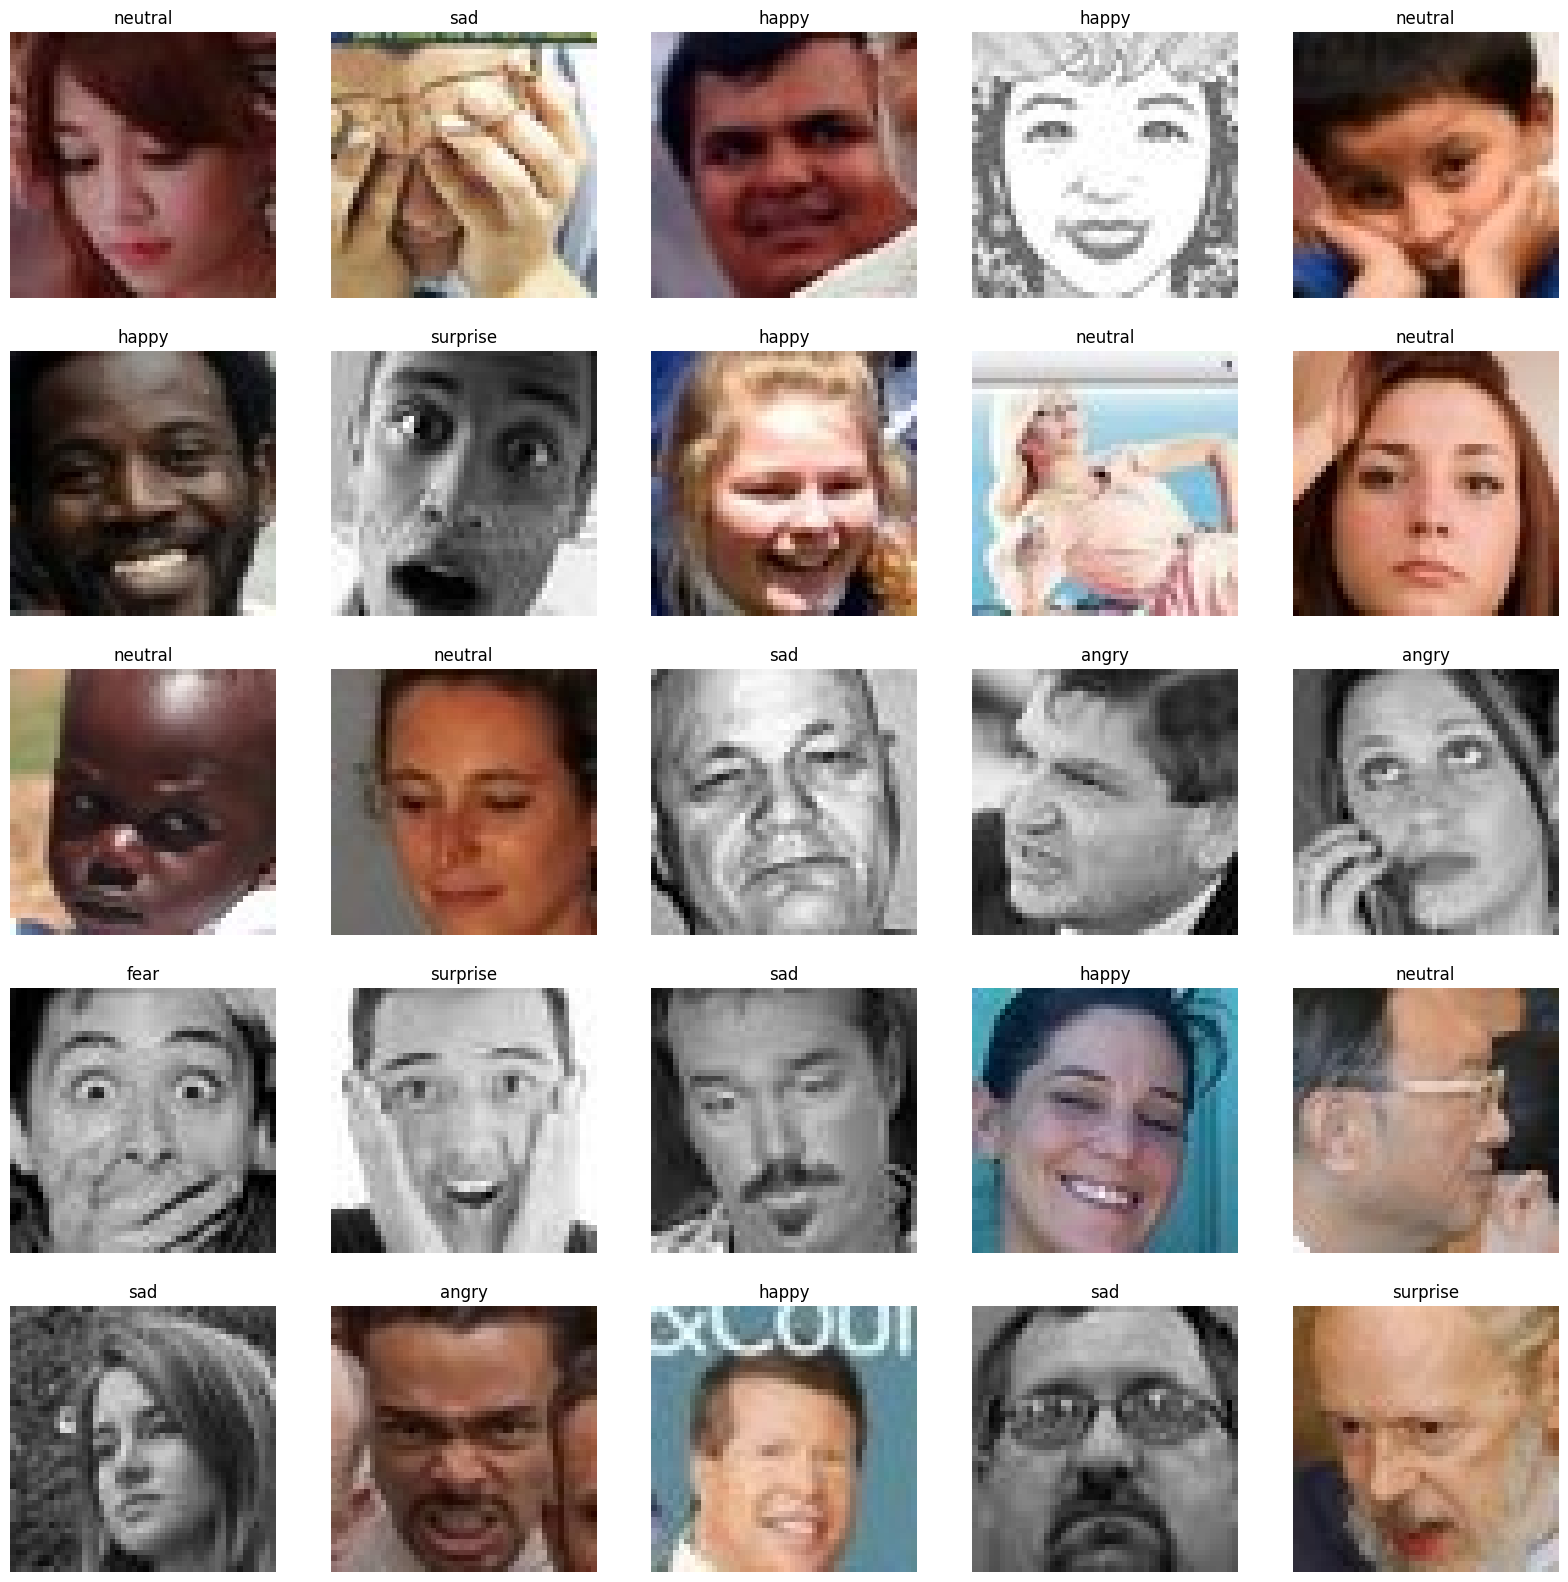

In [43]:
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, image_path, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(image_path)
    img = np.array(img)
    
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [44]:
def extract_features(images):
    features = []
    for image_path in tqdm(images):
        img = load_img(image_path, color_mode='grayscale')
        img = np.array(img)
        
        if DATASET == 'affectnet': # affectnet images are 96x96
            img = img[::2, ::2] # so downsampling to 48x48 is required
        
        features.append(img)
    
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    
    return features

In [45]:
train_features = extract_features(train['image'])
x_train = train_features / 255.0

  0%|          | 0/89373 [00:00<?, ?it/s]

In [46]:
test_features = extract_features(test['image'])
x_test = test_features / 255.0

  0%|          | 0/12767 [00:00<?, ?it/s]

In [47]:
valid_features = extract_features(valid['image'])
x_valid = valid_features / 255.0

  0%|          | 0/25540 [00:00<?, ?it/s]

In [48]:
labels = train['label'].unique()
print(labels)

['neutral' 'sad' 'happy' 'surprise' 'angry' 'fear' 'disgust']


In [49]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(labels)

y_train = le.transform(train['label'])
y_train = to_categorical(y_train, num_classes=len(labels))

y_test = le.transform(test['label'])
y_test = to_categorical(y_test, num_classes=len(labels))

y_valid = le.transform(valid['label'])
y_valid = to_categorical(y_valid, num_classes=len(labels))

In [50]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0.])

In [51]:
input_shape = (48, 48, 1)
output_class = len(labels)

## Model Creation

In [52]:
# # 5 layer model
# model = Sequential(name='5-layer')

# # convolutional layers
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # fatten layer
# model.add(Flatten())

# # fully connected layers
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# # output layer
# model.add(Dense(output_class, activation='softmax'))

# _______________________________________________________

# 6 layer model
model = Sequential(name='6-layer')

# Convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(2048, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

# global average pooling layer
model.add(GlobalAveragePooling2D())

# fully connected layers
model.add(Dense(output_class, activation='softmax'))

In [53]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "6-layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 6, 6, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 6, 6, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 3, 3, 1024)          │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 3, 3, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 1024)          │              

 Total params: 34,545,159 (131.78 MB)

 Trainable params: 34,535,175 (131.74 MB)

 Non-trainable params: 9,984 (39.00 KB)

## Train the model

In [54]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_valid, y_valid)
)

Epoch 1/100
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 1766s 631ms/step - accuracy: 0.3640 - loss: 2.3879 - val_accuracy: 0.3997 - val_loss: 4.3597
Epoch 2/100
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 1765s 632ms/step - accuracy: 0.4847 - loss: 1.7564 - val_accuracy: 0.4747 - val_loss: 1.5302
Epoch 3/100
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 1770s 634ms/step - accuracy: 0.5250 - loss: 1.4433 - val_accuracy: 0.5272 - val_loss: 1.3402
Epoch 4/100
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 1765s 632ms/step - accuracy: 0.5395 - loss: 1.3845 - val_accuracy: 0.5571 - val_loss: 1.8199
Epoch 5/100
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 1772s 634ms/step - accuracy: 0.5606 - loss: 1.2871 - val_accuracy: 0.5566 - val_loss: 1.2287
Epoch 6/100
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 1747s 625ms/step - accuracy: 0.5792 - loss: 1.2050 - val_accuracy: 0.5058 - val_loss: 1.4345
Epoch 7/100
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 1740s 623ms/step - accuracy: 0.5765 - loss: 1.2114 - val_accuracy: 0.6065 - val_loss: 53.0737
Epoch 8/100
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 1739

## Save the model

In [55]:
model.save(f'models/{model.name}_{DATASET}.keras')

## Plot the Results

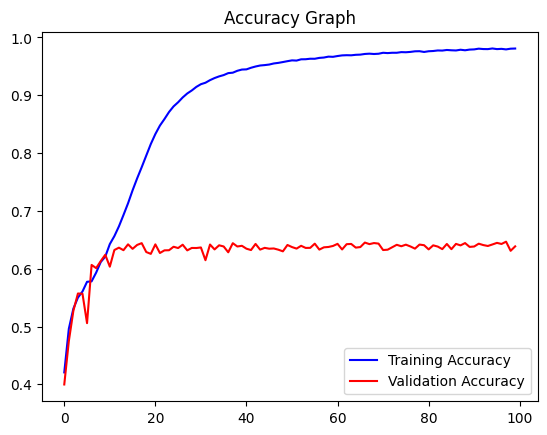

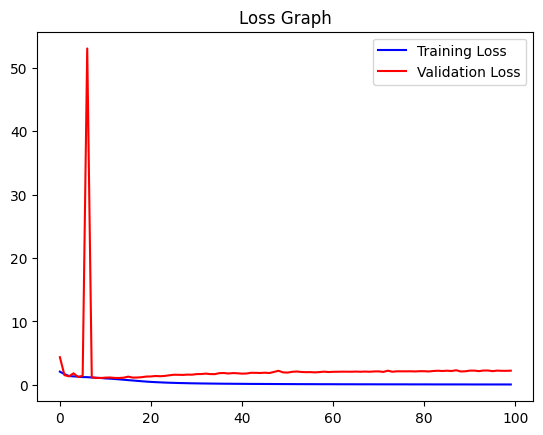

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Accuracy, F1, Precision, Recall

In [57]:
from tensorflow.keras.models import load_model

# model = load_model('models/model.keras')

# Przewidywanie klas na zestawie testowym
y_pred_prob = model.predict(x_test)

399/399 ━━━━━━━━━━━━━━━━━━━━ 49s 122ms/step


In [58]:
y_pred = np.array([np.eye(len(row))[row.argmax()] for row in y_pred_prob])

In [63]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

     neutral       0.52      0.41      0.46       863
         sad       0.39      0.13      0.19       454
       happy       0.44      0.40      0.42       621
    surprise       0.79      0.80      0.79      3952
       angry       0.62      0.75      0.68      4108
        fear       0.47      0.40      0.44      1663
     disgust       0.64      0.57      0.60      1106

   micro avg       0.64      0.64      0.64     12767
   macro avg       0.55      0.49      0.51     12767
weighted avg       0.63      0.64      0.63     12767
 samples avg       0.64      0.64      0.64     12767



In [64]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(acc)

0.6419675726482337


## Confusion matrix

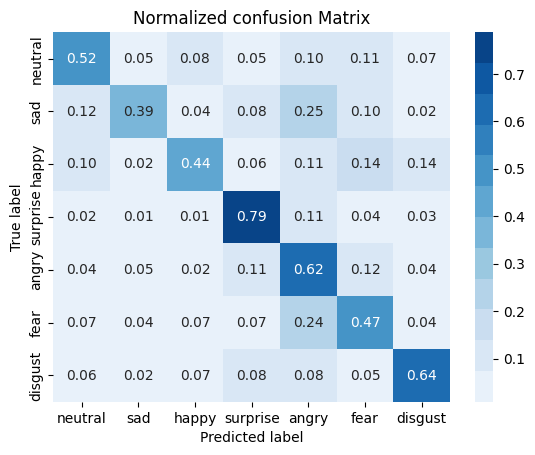

In [65]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(
    le.inverse_transform(np.argmax(y_pred, axis=1)),
    le.inverse_transform(np.argmax(y_test, axis=1)),
    normalize='true'
)

sns.heatmap(
    cm,
    annot=True,
    xticklabels=labels,
    yticklabels=labels,
    cmap=sns.color_palette('Blues', 12),
    fmt='.2f'
)
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Normalized confusion Matrix')
plt.show()

## Test with Image Data

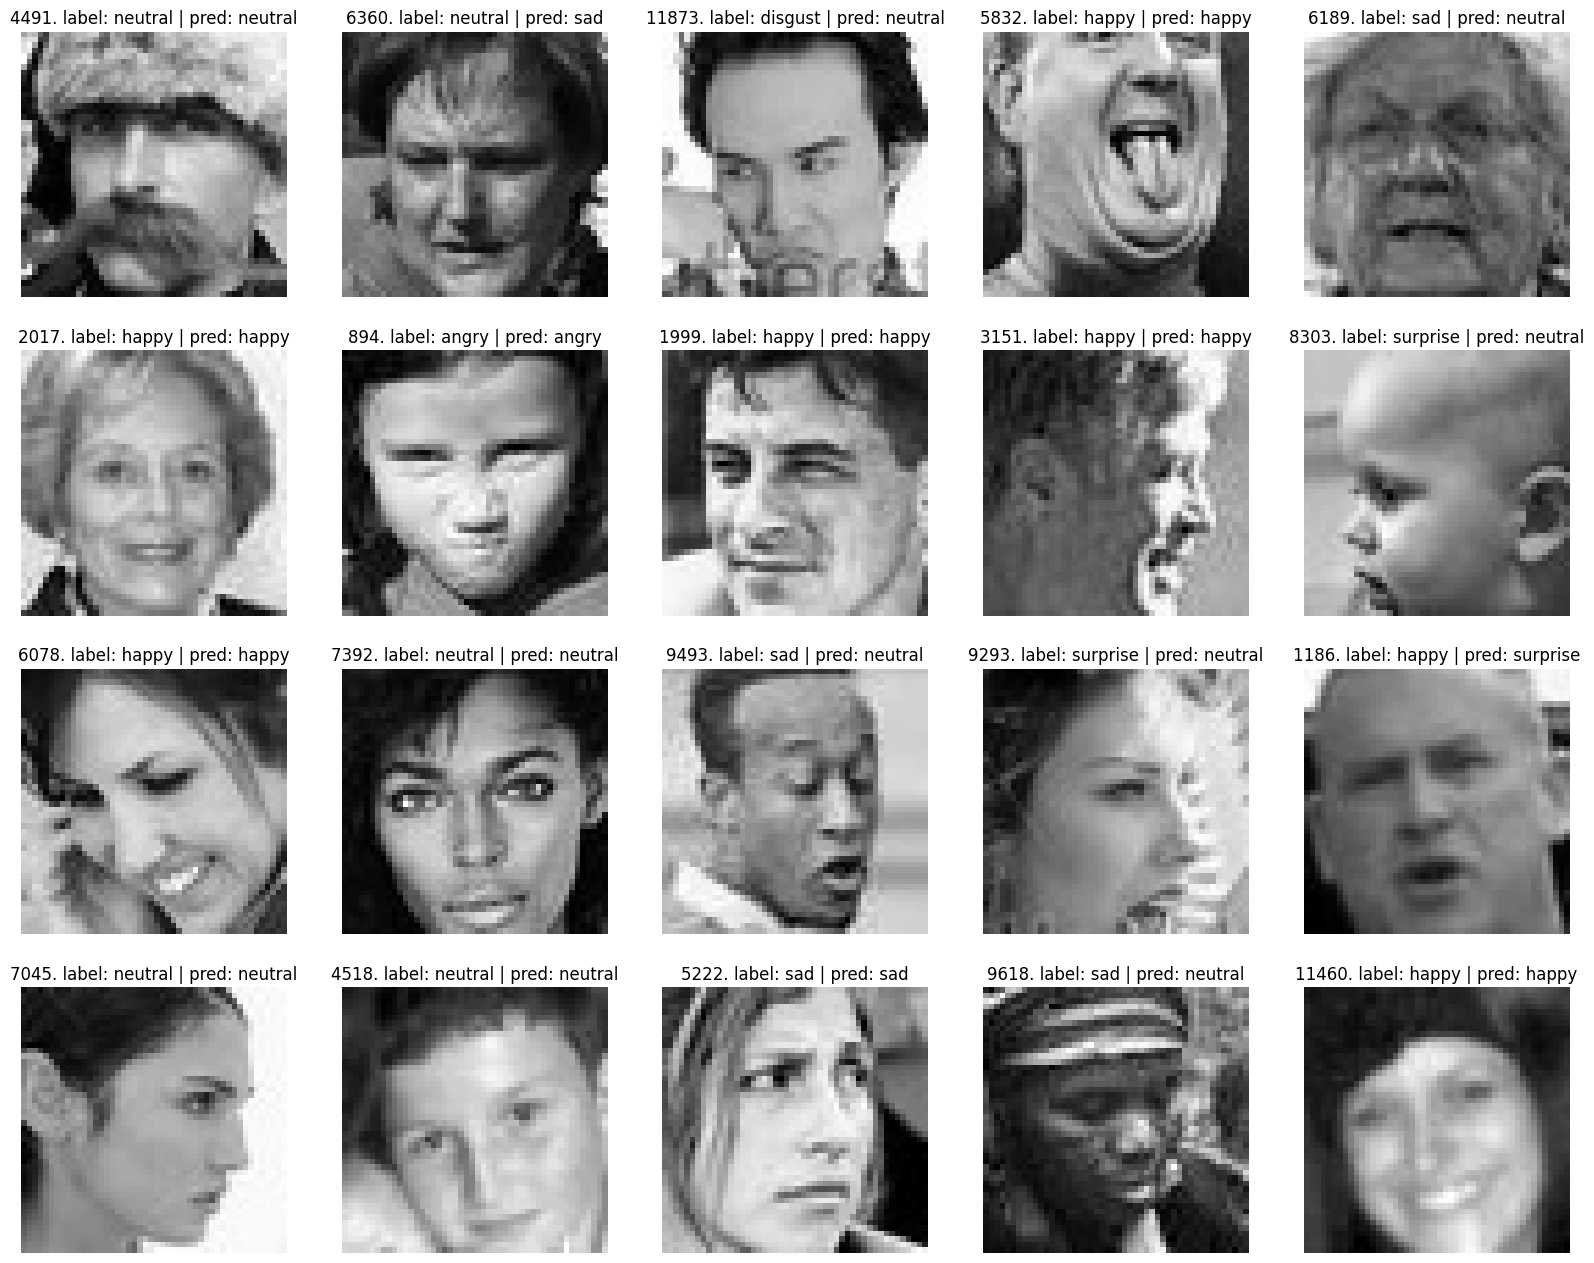

In [66]:
plt.figure(figsize=(20,20))

for i in range(20):
    plt.subplot(5, 5, i+1)

    img_index = random.randint(0, len(test))
    img = x_test[img_index]
    
    label = test['label'][img_index]

    pred = model.predict(img.reshape(1, 48, 48, 1), verbose=0)
    pred_label = le.inverse_transform([pred.argmax()])[0]
    
    plt.title(f"{img_index}. label: {label} | pred: {pred_label}")
    plt.imshow(img.reshape(48, 48), cmap='gray')
    plt.axis('off')